In [196]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [197]:
#Run a linear regression model on PCA_Dataset_With_Mean and GoogleTrendsTimelineCleaned
#load data
pca_dataset = pd.read_csv('./Data/PCA_Dataset_With_Mean.csv',index_col = 0)
gtrends = pd.read_csv('./Data/GoogleTrendsTimelineCleaned.csv', index_col=0)

In [198]:
pca_dataset.index = pd.to_datetime(pca_dataset.index)
gtrends.index = pd.to_datetime(gtrends.index)


In [199]:
pca_dataset = pd.DataFrame(pca_dataset['PCA_mean'])
pca_dataset

,PCA_mean
Date,
2018-10-07,1.205377
2018-10-14,2.077193
2018-10-21,1.376956
2018-10-28,0.864625
2018-11-04,0.967327
...,...
2021-05-02,5.596290
2021-05-09,5.546458
2021-05-16,3.392458


In [200]:
gtrends.index.rename('Date', inplace = True)
gtrends.drop('Cryptocurrency', axis = 1, inplace = True)

[Text(0, 0.5, 'Bitcoin'),
 Text(0, 1.5, 'Ethereum'),
 Text(0, 2.5, 'Bitcoin Cash'),
 Text(0, 3.5, 'Dogecoin')]

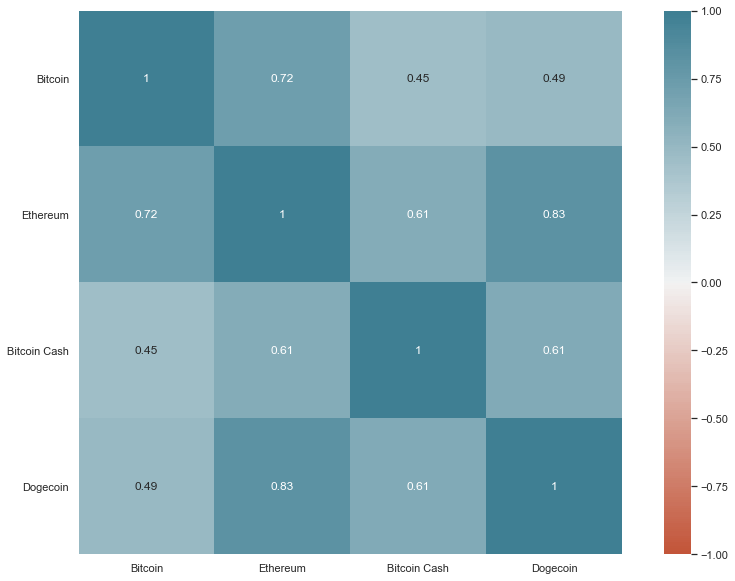

In [201]:
#Check for colinearity in google trends dataset

corr = gtrends.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation =0)

In [202]:
#This data is highly correlated. We need to decorrelate these columns. 
#Task 1 - how to decorrelate?
gtrends['Avg_Doge_Ether'] = (gtrends['Dogecoin'] + gtrends['Ethereum'])/2
gtrends.drop(['Ethereum', 'Dogecoin'],axis = 1, inplace = True)


In [203]:
gtrends

,Bitcoin,Bitcoin Cash,Avg_Doge_Ether
Date,,,
2018-10-07,8,0,0.5
2018-10-14,9,0,0.5
2018-10-21,8,0,0.5
2018-10-28,8,0,0.5
2018-11-04,8,1,0.5
...,...,...,...
2021-05-02,35,1,26.5
2021-05-09,43,1,27.5
2021-05-16,74,1,17.0


In [204]:
trends_price = gtrends.merge(pca_dataset, on='Date', left_index = True)
trends_price

,Bitcoin,Bitcoin Cash,Avg_Doge_Ether,PCA_mean
Date,,,,
2018-10-07,8,0,0.5,1.205377
2018-10-14,9,0,0.5,2.077193
2018-10-21,8,0,0.5,1.376956
2018-10-28,8,0,0.5,0.864625
2018-11-04,8,1,0.5,0.967327
...,...,...,...,...
2021-05-02,35,1,26.5,5.596290
2021-05-09,43,1,27.5,5.546458
2021-05-16,74,1,17.0,3.392458


In [205]:
sns.set(rc={'figure.figsize':(15,10)})
sns.scatterplot(x=trends_price['Avg_Popularity'],y=trends_price['PCA_mean'])
plt.legend(labels=['Avg_Popularity'])
plt.show()

KeyError: 'Avg_Popularity'

In [ ]:
#Create Train Test Spilt

X = trends_price.drop('PCA_mean', axis =1)
y = trends_price['PCA_mean']

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size =0.3, shuffle = True, random_state = 2)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate


sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform (X_test)

In [ ]:
reg = LinearRegression()
reg.fit(X_train,y_train)

r_sq = reg.score(X_train, y_train)
print('R-squared: {:.2f}'.format(r_sq * 100))

y_pred=reg.predict(X_test)

Our model is about 48.9% accurate

In [ ]:
print("The MSE is: {}".format(mean_squared_error(y_test, y_pred)))
print('The MAE is: {}'.format(mean_absolute_error(y_test, y_pred)))

From the MAE, on average our prediction is about 0.46 off from the true value

In [ ]:
#Cross Validate
#Task 2 - Am i doing this wrong?
score = cross_val_score(reg,X_train,y_train,cv=5)
print('Cross-validated scores: {}'.format(score))

In [ ]:
#Stats Model
import statsmodels.api as sm

X2 = sm.add_constant(X)

regstats = sm.OLS(y,X2)
stats= regstats.fit()
pred = stats.predict()

In [ ]:
stats.summary()

## Model 2 - Random Forest with GridSearchCV

In [207]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

#Remake X, y test spilt based on all Google trends
rf_X = trends_price.drop('PCA_mean',axis =1)
rf_y = trends_price['PCA_mean']

rf_X_train, rf_X_test,rf_y_train,rf_y_test = train_test_split(rf_X,rf_y,test_size =0.3, shuffle = True, random_state = 2)


rf_pipe = make_pipeline(
    StandardScaler(),
RandomForestRegressor(random_state = 2))

max_features = ['auto', 'sqrt']
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=30)]


grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
    'randomforestregressor__max_features':max_features
}

In [208]:
rf_grid = GridSearchCV(rf_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [209]:
rf_grid.fit(rf_X_train,rf_y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=2))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_features': ['auto',
                                                                 'sqrt'],
                         'randomforestregressor__n_estimators': [10, 11, 13, 16,
                                                                 18, 22, 25, 30,
                                                                 35, 41, 48, 57,
                                                                 67, 78, 92,
                                                                 108, 126, 148,
                                                                 174, 204, 239,
                                                                 280, 329, 385,
                          

In [210]:
rf_grid.best_params_

{'randomforestregressor__max_features': 'auto',
 'randomforestregressor__n_estimators': 11,
 'standardscaler': StandardScaler()}

In [211]:
rf_grid.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=11, random_state=2))])

## Random Forest Model Performance

In [213]:
#Model Performance

rf_score = cross_val_score(rf_grid.best_estimator_,rf_X_train,rf_y_train,cv=5)
print('Cross-validated scores: {}'.format(rf_score))

print('Model Accuracy: {:.2f}'.format(rf_grid.score(rf_X_train,rf_y_train)*100))

#MAE Score
rf_y_pred = rf_grid.predict(rf_X_test) 

print('The MAE is: {:.2f}'.format(mean_absolute_error(rf_y_test, rf_y_pred)))
print("The MSE is: {:.2f}".format(mean_squared_error(rf_y_test, rf_y_pred)))

Cross-validated scores: [0.36885906 0.81983846 0.73805007 0.61598088 0.77173162]
Model Accuracy: 88.99
The MAE is: 0.33
The MSE is: 0.18


Our model is 89% accurate with an average of 0.33 off the true value 

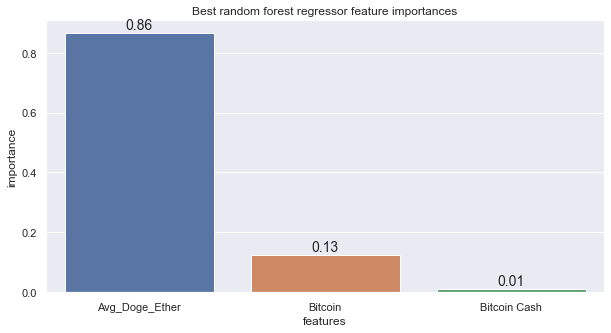

In [214]:
plt.subplots(figsize=(10, 5))

ax = plt.subplot()
imps = rf_grid.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=rf_X_train.columns).sort_values(ascending=False)
plots = sns.barplot(x = rf_feat_imps.index, y = rf_feat_imps)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances')

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=14, xytext=(0, 8),
                   textcoords='offset points')

Cryptocurrency is the most important trend that impacts the price, after that is a sharp decline with Dogecoin and Ethereum. 

## Model #3 - Ridge Regression 

Our Independent variables are correlated with each other. Lets use Ridge Regression model and see how it performs

In [215]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

rr_pipe = make_pipeline(
    StandardScaler(),
    Ridge())

grid_params = {
        'ridge__alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
}

ridge_reg= GridSearchCV(rr_pipe, grid_params,cv=5, n_jobs = -1)

#fit the grid search
ridge_reg.fit(rf_X_train,rf_y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001,
                                          0.01, 1, 5, 10, 20]})

In [216]:
ridge_reg.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=1))])

In [217]:
ridge_score = cross_val_score(ridge_reg.best_estimator_,rf_X_train,rf_y_train,cv=5)
print('Cross-validated scores: {}'.format(ridge_score))

ridge_reg.score(rf_X_train,rf_y_train)

Cross-validated scores: [0.07390063 0.76854843 0.54047685 0.44437004 0.8354972 ]


0.6590169453284854

In [165]:
#MSE Score
#MAE Score
rr_y_pred = ridge_reg.predict(rf_X_test) 

print('Ridge Regression Model Accuracy: {:.2f}'.format(ridge_reg.score(rf_X_train,rf_y_train) * 100))
print('The MAE is: {:.2f}'.format(mean_absolute_error(rf_y_test, rr_y_pred)))

print("The MSE is: {:.2f}".format(mean_squared_error(rf_y_test, rr_y_pred)))

Ridge Regression Model Accuracy: 80.58
The MAE is: 0.40
The MSE is: 0.31


Our model is 80.6% accurate. Our predictitions are an average of 0.40 from the true value

## Finding the right model

Lets look at performance for linear regression and Random forest again

In [166]:
#Linear Regression Model Performance
r_sq = reg.score(X_train, y_train)
print('Linear Regression Model Accuracy: {:.2f}'.format(r_sq * 100))
print('The MAE is: {:.2f}'.format(mean_absolute_error(y_test, y_pred)))
print("The MSE is: {:.2f}".format(mean_squared_error(y_test, y_pred)))

Linear Regression Model Accuracy: 48.85
The MAE is: 0.46
The MSE is: 0.37


In [164]:
#Random Forest Model Performance
print('Random Forest Model Accuracy: {:.2f}'.format(rf_grid.score(rf_X_train,rf_y_train)*100))
print('The MAE is: {:.2f}'.format(mean_absolute_error(rf_y_test, rf_y_pred)))
print("The MSE is: {:.2f}".format(mean_squared_error(rf_y_test, rf_y_pred)))

Random Forest Model Accuracy: 88.78
The MAE is: 0.33
The MSE is: 0.18


Random Forest has the highest model accuracy and the lowest MAE and MSE. 

For those reasons we choose Random Forest as our model for this problem. 


In our feature importance visualization for Random Forest, we can see that the google search trend "Cryptocurrency" has the most impact on the price of cryptocurrencies. After that is a sharp decline, with Dogecoin and Ethereum.

We might be able to hypothesize that Dogecoin is a much more voliate cryptocurency and depends heavily on consumer interest to keep the price at a certain level. 